***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
     </ol>
     <br>

In [43]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats
import re

from xgboost import XGBClassifier
from xgboost import plot_importance

In [44]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
    
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [45]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression(random_state=0)
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier(random_state=0)
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier(random_state=0)
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier(random_state=0)
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier(random_state=0)
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier(random_state=0)
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    fpr, tpr, threshold = roc_curve(Y_test, deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    roc_auc =auc(fpr, tpr)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

#### Read Data

In [46]:
df=pd.read_csv('../html/HTML.csv',index_col='domain')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df.columns if 'number' in col]
df.drop(cookie,axis=1,inplace=True)
print("Shape of HTML dataset:",df.shape)

df.Target=df.Target.apply(lambda x: 1 if x=='Malicious' else 0)

Shape of HTML dataset: (43491, 1461)


#### Dropping constants

In [47]:
col_no_unique=[]
for col in df.columns[:-1]:
    if len(df[col].value_counts())==1:
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))
### Drop those columns
df.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df.shape)

0 columns have only one unique value in them rendering them meaningless for classification
Shape of our dataset after dropping them: (43491, 1461)


#### 95% same values

In [48]:
lst=[]
for col in df.columns[:-1]:
    lst.append([col,dict(df[col].value_counts()),df[col].value_counts().values[0]>=len(df)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst

print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

1297 columns have more than 95% same values


In [49]:
df.drop(col_values[col_values['95_%_same_values']==True].index.values,axis=1,inplace=True)

#### Dropping columns based on high VIF values

In [50]:
df_sel=df.copy(deep=True)
rem=['a_href_absolute','a_href_relative','a_count','a_href_out_of_domain',
     'base_count','base_href_absolute','base_href_out_of_domain',
     'iframe_src_absolute','iframe_src_relative','iframe_sandbox_allow_same_origin_count','iframe_src_http',
     'img_src_absolute','img_src_http','img_srcset_absolute','img_src_relative','img_srcset_relative','img_count',
     'script_src_absolute','script_src_http','script_src_relative','script_count','script_src_https',
     'link_rel_wlwmanifest','link_href_absolute','link_href_relative','link_rel_EditURI','link_count',
     'link_type_application/wlwmanifest+xml','link_href_https','link_rel_stylesheet','link_href_.png',
     'form_action_absolute','form_action_relative','form_count','form_action_https',
     'form_enctype_application/x-www-form-urlencoded',
     'tbody_count',
     'nofollow_count']

df_sel.drop(rem,axis=1,inplace=True)

In [51]:
X=df_sel.iloc[:,df_sel.columns!='Target']
Y=df_sel.Target

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

In [54]:
model = XGBClassifier(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
thresholds = np.sort(model.feature_importances_)

Accuracy: 90.11%


In [15]:
for thresh in thresholds:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    selection_model = XGBClassifier(random_state=0)
    selection_model.fit(select_X_train, y_train)
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90

In [55]:
# select features using threshold
selection = SelectFromModel(model, threshold=0.009, prefit=True)
# selection = SelectFromModel(model, threshold=0.012, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier(random_state=0)
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)

selection_model = selection.get_support()
embeded_rf_feature = X.loc[:,selection_model].columns.tolist()

In [56]:
embeded_rf_feature.append('Target')
embeded_rf_feature

['a_href_.aspx',
 'a_href_.com',
 'a_href_http',
 'a_href_https',
 'b_count',
 'br_count',
 'center_count',
 'div_count',
 'form_action_http',
 'form_action_out_of_domain',
 'h1_count',
 'iframe_src_https',
 'img_src_.jpg',
 'input_count',
 'li_count',
 'link_href_.css',
 'link_href_0',
 'link_href_http',
 'link_href_out_of_domain',
 'link_rel_shortlink',
 'link_type_application/rsd+xml',
 'link_type_application/rss+xml',
 'link_type_text/css',
 'meta_count',
 'p_count',
 'script_async_true',
 'script_charset_UTF-8',
 'script_defer_true',
 'script_src_.js',
 'script_src_out_of_domain',
 'script_type_text/javascript',
 'section_count',
 'span_count',
 'strong_count',
 'title_count',
 'Target']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [57]:
fin_col=embeded_rf_feature

In [58]:
df_sel=df_sel[fin_col]

In [60]:
train=df_sel.iloc[:34793,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel[fin_col].iloc[34793:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

In [61]:
columns=fin_col
columns.remove('Target')

In [62]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9087747535423792
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27004  2687    29691
True         487  4615     5102
__all__    27491  7302    34793

Accuracy of the model for test data is: 0.9021614164175673
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6706   717     7423
True         134  1141     1275
__all__     6840  1858     8698



Logistic Regression
Accuracy of the model for training data is: 0.889259333774035
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27012  2679    29691
True        1174  3928     5102
__all__    28186  6607    34793

Accuracy of the model for test data is: 0.8831915382846631
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6712   711     7423
True         305   970     1275
__all__     7017  1681     8698



RandomForest Classifier
Accuracy of the model for training data is: 0.9188917310953353
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27088  2603    29691
True         219  4883     5102
__all__    27307  7486    34793

Accuracy of the model for test data is: 0.9051506093354794
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6728   695     7423
True         130  1145     1275
__all__     6858  1840     8698



Adaoost Classifier
Accuracy of the model for training data is: 0.896042307360676
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26857  2834    29691
True         783  4319     5102
__all__    27640  7153    34793

Accuracy of the model for test data is: 0.8906645205794436
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6675   748     7423
True         203  1072     1275
__all__     6878  1820     8698



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9044635415169718
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27068  2623    29691
True         701  4401     5102
__all__    27769  7024    34793

Accuracy of the model for test data is: 0.8983674407909864
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6725   698     7423
True         186  1089     1275
__all__     6911  1787     8698

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.exception() is not None:
concurrent.futures._base.CancelledError
Exception ignored in: <bound method



ExtraTree Classifier
Accuracy of the model for training data is: 0.9209898542810335
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27089  2602    29691
True         147  4955     5102
__all__    27236  7557    34793

Accuracy of the model for test data is: 0.9054955162106232
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6727   696     7423
True         126  1149     1275
__all__     6853  1845     8698



Bagging Classifier
Accuracy of the model for training data is: 0.9188917310953353
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27085  2606    29691
True         216  4886     5102
__all__    27301  7492    34793

Accuracy of the model for test data is: 0.9043458266268107
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6717   706     7423
True         126  1149     1275
__all__     6843  1855     8698



Neural Network-1
The accuracy of the model on training data is: 0.9112465151036128


Predicted  False  True  __all__
Actual                         
False      26958  2733    29691
True         355  4747     5102
__all__    27313  7480    34793

The accuracy of the model on test data is: 0.895723154748218


Predicted  False  True  __all__
Actual                         
False       6660   763     7423
True         144  1131     1275
__all__     6804  1894     8698

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [63]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [64]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.908775,4615.0,27004.0,2687.0,487.0,0.090499,0.095453
LogisticRegression,0.889259,3928.0,27012.0,2679.0,1174.0,0.090229,0.230106
RandomForestClassifier,0.918892,4883.0,27088.0,2603.0,219.0,0.087670,0.042924
AdaBoostClassifier,0.896042,4319.0,26857.0,2834.0,783.0,0.095450,0.153469
GradientBoostingClassifier,0.904464,4401.0,27068.0,2623.0,701.0,0.088343,0.137397
ExtraTreeClassifier,0.920990,4955.0,27089.0,2602.0,147.0,0.087636,0.028812
BaggingClassifier,0.918892,4886.0,27085.0,2606.0,216.0,0.087771,0.042336
Neural Network-1,0.911247,4747.0,26958.0,2733.0,355.0,0.092048,0.069581


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.902161,1141.0,6706.0,717.0,134.0,0.096592,0.105098,0.899155,0.688915
LogisticRegression,0.883192,970.0,6712.0,711.0,305.0,0.095783,0.239216,0.832500,0.595672
RandomForestClassifier,0.905151,1145.0,6728.0,695.0,130.0,0.093628,0.101961,0.902206,0.696651
AdaBoostClassifier,0.890665,1072.0,6675.0,748.0,203.0,0.100768,0.159216,0.870008,0.643457
GradientBoostingClassifier,0.898367,1089.0,6725.0,698.0,186.0,0.094032,0.145882,0.880043,0.665387
ExtraTreeClassifier,0.905496,1149.0,6727.0,696.0,126.0,0.093763,0.098824,0.903707,0.698558
BaggingClassifier,0.904346,1149.0,6717.0,706.0,126.0,0.095110,0.098824,0.903033,0.696018
Neural Network-1,0.895723,1131.0,6660.0,763.0,144.0,0.102789,0.112941,0.892135,0.672107


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [65]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [66]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

In [67]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors


distributed.core - INFO - Event loop was unresponsive in Nanny for 6.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

Accuracy of the model for training data is: 0.5957866020006063
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28759   932    29691
True       23071  6620    29691
__all__    51830  7552    59382

Accuracy of the model for test data is: 0.8492756955621982
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7152   271     7423
True        1040   235     1275
__all__     8192   506     8698



Logistic Regression
Accuracy of the model for training data is: 0.8893940924859385
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24326   5365    29691
True        1203  28488    29691
__all__    25529  33853    59382

Accuracy of the model for test data is: 0.8313405380547252
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6010  1413     7423
True          54  1221     1275
__all__     6064  2634     8698



RandomForest Classifier
Accuracy of the model for training data is: 0.9470209827893975
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26972   2719    29691
True         427  29264    29691
__all__    27399  31983    59382

Accuracy of the model for test data is: 0.9036560128765233
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6688   735     7423
True         103  1172     1275
__all__     6791  1907     8698



Adaoost Classifier
Accuracy of the model for training data is: 0.9052406453133947
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25408   4283    29691
True        1344  28347    29691
__all__    26752  32630    59382

Accuracy of the model for test data is: 0.8592779949413658
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6276  1147     7423
True          77  1198     1275
__all__     6353  2345     8698



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9220302448553434
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26095   3596    29691
True        1034  28657    29691
__all__    27129  32253    59382

Accuracy of the model for test data is: 0.879742469533226
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6469   954     7423
True          92  1183     1275
__all__     6561  2137     8698



ExtraTree Classifier
Accuracy of the model for training data is: 0.9477619480650702
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26976   2715    29691
True         387  29304    29691
__all__    27363  32019    59382

Accuracy of the model for test data is: 0.9030811680846171
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6691   732     7423
True         111  1164     1275
__all__     6802  1896     8698



Bagging Classifier
Accuracy of the model for training data is: 0.947088343269004
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26971   2720    29691
True         422  29269    29691
__all__    27393  31989    59382

Accuracy of the model for test data is: 0.9023913543343297
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6674   749     7423
True         100  1175     1275
__all__     6774  1924     8698



Neural Network-1
The accuracy of the model on training data is: 0.9340204102192983


Predicted  False   True  __all__
Actual                          
False      26193   3498    29691
True         420  29271    29691
__all__    26613  32769    59382

The accuracy of the model on test data is: 0.8736491147390205


Predicted  False  True  __all__
Actual                         
False       6404  1019     7423
True          80  1195     1275
__all__     6484  2214     8698

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [68]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [69]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.595787,6620.0,28759.0,932.0,23071.0,0.031390,0.777037
LogisticRegression,0.889394,28488.0,24326.0,5365.0,1203.0,0.180694,0.040517
RandomForestClassifier,0.947021,29264.0,26972.0,2719.0,427.0,0.091577,0.014381
AdaBoostClassifier,0.905241,28347.0,25408.0,4283.0,1344.0,0.144252,0.045266
GradientBoostingClassifier,0.922030,28657.0,26095.0,3596.0,1034.0,0.121114,0.034825
ExtraTreeClassifier,0.947762,29304.0,26976.0,2715.0,387.0,0.091442,0.013034
BaggingClassifier,0.947088,29269.0,26971.0,2720.0,422.0,0.091610,0.014213
Neural Network-1,0.934020,29271.0,26193.0,3498.0,420.0,0.117813,0.014146


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.849276,235.0,7152.0,271.0,1040.0,0.036508,0.815686,0.573903,0.223339
LogisticRegression,0.831341,1221.0,6010.0,1413.0,54.0,0.190354,0.042353,0.883646,0.590634
RandomForestClassifier,0.903656,1172.0,6688.0,735.0,103.0,0.099017,0.080784,0.910100,0.701168
AdaBoostClassifier,0.859278,1198.0,6276.0,1147.0,77.0,0.154520,0.060392,0.892544,0.625752
GradientBoostingClassifier,0.879742,1183.0,6469.0,954.0,92.0,0.128519,0.072157,0.899662,0.656720
ExtraTreeClassifier,0.903081,1164.0,6691.0,732.0,111.0,0.098612,0.087059,0.907164,0.697601
BaggingClassifier,0.902391,1175.0,6674.0,749.0,100.0,0.100903,0.078431,0.910333,0.699336
Neural Network-1,0.873649,1195.0,6404.0,1019.0,80.0,0.137276,0.062745,0.899989,0.649551


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [70]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [71]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)

## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

Shape after undersampling (10204, 35)
K-Nearest Neighbors
Accuracy of the model for training data is: 0.5737945903567229
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4940   162     5102
True        4187   915     5102
__all__     9127  1077    10204

Accuracy of the model for test data is: 0.839503334099793
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7074   349     7423
True        1047   228     1275
__all__     8121   577     8698



Logistic Regression
Accuracy of the model for training data is: 0.8859270874166993
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4153   949     5102
True         215  4887     5102
__all__     4368  5836    10204

Accuracy of the model for test data is: 0.824442400551851
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5944  1479     7423
True          48  1227     1275
__all__     5992  2706     8698



RandomForest Classifier
Accuracy of the model for training data is: 0.9440415523324187
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4624   478     5102
True          93  5009     5102
__all__     4717  5487    10204

Accuracy of the model for test data is: 0.8950333409979305
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6595   828     7423
True          85  1190     1275
__all__     6680  2018     8698



Adaoost Classifier
Accuracy of the model for training data is: 0.8977851822814582
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4375   727     5102
True         316  4786     5102
__all__     4691  5513    10204

Accuracy of the model for test data is: 0.8549091745228788
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6238  1185     7423
True          77  1198     1275
__all__     6315  2383     8698



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9111132889063113
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4442   660     5102
True         247  4855     5102
__all__     4689  5515    10204

Accuracy of the model for test data is: 0.8680156357783398
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6343  1080     7423
True          68  1207     1275
__all__     6411  2287     8698



ExtraTree Classifier
Accuracy of the model for training data is: 0.9468835750686005
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4634   468     5102
True          74  5028     5102
__all__     4708  5496    10204

Accuracy of the model for test data is: 0.8968728443320304
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6614   809     7423
True          88  1187     1275
__all__     6702  1996     8698



Bagging Classifier
Accuracy of the model for training data is: 0.9436495491963935
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4625   477     5102
True          98  5004     5102
__all__     4723  5481    10204

Accuracy of the model for test data is: 0.8875603587031502
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6526   897     7423
True          81  1194     1275
__all__     6607  2091     8698



Neural Network-1
The accuracy of the model on training data is: 0.927479419765263


Predicted  False  True  __all__
Actual                         
False       4454   648     5102
True          92  5010     5102
__all__     4546  5658    10204

The accuracy of the model on test data is: 0.8595079328581283


Predicted  False  True  __all__
Actual                         
False       6254  1169     7423
True          53  1222     1275
__all__     6307  2391     8698

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [72]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [73]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.573795,915.0,4940.0,162.0,4187.0,0.031752,0.820659
LogisticRegression,0.885927,4887.0,4153.0,949.0,215.0,0.186005,0.042140
RandomForestClassifier,0.944042,5009.0,4624.0,478.0,93.0,0.093689,0.018228
AdaBoostClassifier,0.897785,4786.0,4375.0,727.0,316.0,0.142493,0.061936
GradientBoostingClassifier,0.911113,4855.0,4442.0,660.0,247.0,0.129361,0.048412
ExtraTreeClassifier,0.946884,5028.0,4634.0,468.0,74.0,0.091729,0.014504
BaggingClassifier,0.943650,5004.0,4625.0,477.0,98.0,0.093493,0.019208
Neural Network-1,0.927479,5010.0,4454.0,648.0,92.0,0.127009,0.018032


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.839503,228.0,7074.0,349.0,1047.0,0.047016,0.821176,0.565904,0.187324
LogisticRegression,0.824442,1227.0,5944.0,1479.0,48.0,0.199246,0.037647,0.881554,0.583016
RandomForestClassifier,0.895033,1190.0,6595.0,828.0,85.0,0.111545,0.066667,0.910894,0.688582
AdaBoostClassifier,0.854909,1198.0,6238.0,1185.0,77.0,0.159639,0.060392,0.889984,0.618548
GradientBoostingClassifier,0.868016,1207.0,6343.0,1080.0,68.0,0.145494,0.053333,0.900586,0.643688
ExtraTreeClassifier,0.896873,1187.0,6614.0,809.0,88.0,0.108986,0.069020,0.910997,0.691403
BaggingClassifier,0.887560,1194.0,6526.0,897.0,81.0,0.120841,0.063529,0.907815,0.675086
Neural Network-1,0.859508,1222.0,6254.0,1169.0,53.0,0.157483,0.041569,0.900474,0.634524


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [74]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [75]:
df_sel.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df_sel[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 2415 features
EntitySet scattered to workers in 4.891 seconds
Elapsed: 00:12 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.ex

In [76]:
df_sel.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df_sel.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

In [78]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [79]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)



X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [80]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(43491, 31)

In [81]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['link_href_0 + script_src_.js',
 'form_action_out_of_domain + script_src_.js',
 'div_count + meta_count',
 'center_count + script_src_.js',
 'script_type_text/javascript + title_count',
 'script_src_.js / title_count',
 'script_src_.js / link_href_.css',
 'script_src_.js + script_src_out_of_domain',
 'script_src_.js',
 'script_async_true + script_src_out_of_domain',
 'script_async_true + script_src_.js',
 'link_type_text/css + script_src_.js',
 'link_type_application/rss+xml + script_src_.js',
 'link_type_application/rsd+xml + script_src_.js',
 'link_rel_shortlink + script_src_.js',
 'link_href_out_of_domain + script_type_text/javascript',
 'link_href_out_of_domain + script_async_true',
 'link_href_.css + script_src_.js',
 'img_src_.jpg + script_src_.js',
 'img_src_.jpg + script_async_true',
 'img_src_.jpg + link_href_out_of_domain',
 'iframe_src_https + script_src_out_of_domain',
 'iframe_src_https + script_src_.js',
 'form_action_out_of_domain + script_src_out_of_domain',
 'form_act

In [82]:
fs=fs.reindex(df_sel.index.values)

train=fs.iloc[:34793]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[34793:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [83]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])


feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.907682579829276
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26985  2706    29691
True         506  4596     5102
__all__    27491  7302    34793

Accuracy of the model for test data is: 0.8994021614164176
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6688   735     7423
True         140  1135     1275
__all__     6828  1870     8698



Logistic Regression
Accuracy of the model for training data is: 0.8897766792170839
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27008  2683    29691
True        1152  3950     5102
__all__    28160  6633    34793

Accuracy of the model for test data is: 0.8833065072430444
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6710   713     7423
True         302   973     1275
__all__     7012  1686     8698



RandomForest Classifier
Accuracy of the model for training data is: 0.9176271089012158
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27045  2646    29691
True         220  4882     5102
__all__    27265  7528    34793

Accuracy of the model for test data is: 0.9036560128765233
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6715   708     7423
True         130  1145     1275
__all__     6845  1853     8698



Adaoost Classifier


distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.exception() is not None:
concurrent.futures._base.CancelledError
Exception ignored in: <bound method

Accuracy of the model for training data is: 0.8958698588796598
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26954  2737    29691
True         886  4216     5102
__all__    27840  6953    34793

Accuracy of the model for test data is: 0.8912393653713497
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6704   719     7423
True         227  1048     1275
__all__     6931  1767     8698



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9039461960739229
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27036  2655    29691
True         687  4415     5102
__all__    27723  7070    34793

Accuracy of the model for test data is: 0.897677627040699
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6712   711     7423
True         179  1096     1275
__all__     6891  1807     8698



ExtraTree Classifier
Accuracy of the model for training data is: 0.9199839048084385
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27047  2644    29691
True         140  4962     5102
__all__    27187  7606    34793

Accuracy of the model for test data is: 0.903541043918142
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6712   711     7423
True         128  1147     1275
__all__     6840  1858     8698



Bagging Classifier
Accuracy of the model for training data is: 0.9172534705256804
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27044  2647    29691
True         232  4870     5102
__all__    27276  7517    34793

Accuracy of the model for test data is: 0.902506323292711
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6699   724     7423
True         124  1151     1275
__all__     6823  1875     8698



Neural Network-1
The accuracy of the model on training data is: 0.8902940246618459


Predicted  False  True  __all__
Actual                         
False      26349  3342    29691
True         475  4627     5102
__all__    26824  7969    34793

The accuracy of the model on test data is: 0.8768682455736951


Predicted  False  True  __all__
Actual                         
False       6494   929     7423
True         142  1133     1275
__all__     6636  2062     8698

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [84]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [85]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.907683,4596.0,26985.0,2706.0,506.0,0.091139,0.099177
LogisticRegression,0.889777,3950.0,27008.0,2683.0,1152.0,0.090364,0.225794
RandomForestClassifier,0.917627,4882.0,27045.0,2646.0,220.0,0.089118,0.043120
AdaBoostClassifier,0.895870,4216.0,26954.0,2737.0,886.0,0.092183,0.173657
GradientBoostingClassifier,0.903946,4415.0,27036.0,2655.0,687.0,0.089421,0.134653
ExtraTreeClassifier,0.919984,4962.0,27047.0,2644.0,140.0,0.089051,0.027440
BaggingClassifier,0.917253,4870.0,27044.0,2647.0,232.0,0.089152,0.045472
Neural Network-1,0.890294,4627.0,26349.0,3342.0,475.0,0.112559,0.093101


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.899402,1135.0,6688.0,735.0,140.0,0.099017,0.109804,0.895590,0.681165
LogisticRegression,0.883307,973.0,6710.0,713.0,302.0,0.096053,0.236863,0.833542,0.596865
RandomForestClassifier,0.903656,1145.0,6715.0,708.0,130.0,0.095379,0.101961,0.901330,0.693349
AdaBoostClassifier,0.891239,1048.0,6704.0,719.0,227.0,0.096861,0.178039,0.862550,0.637421
GradientBoostingClassifier,0.897678,1096.0,6712.0,711.0,179.0,0.095783,0.140392,0.881912,0.665914
ExtraTreeClassifier,0.903541,1147.0,6712.0,711.0,128.0,0.095783,0.100392,0.901912,0.693674
BaggingClassifier,0.902506,1151.0,6699.0,724.0,124.0,0.097535,0.097255,0.902605,0.692574
Neural Network-1,0.876868,1133.0,6494.0,929.0,142.0,0.125152,0.111373,0.881738,0.634955


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [86]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

distributed.core - INFO - Event loop was unresponsive in Nanny for 103.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 103.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 103.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 103.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 103.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

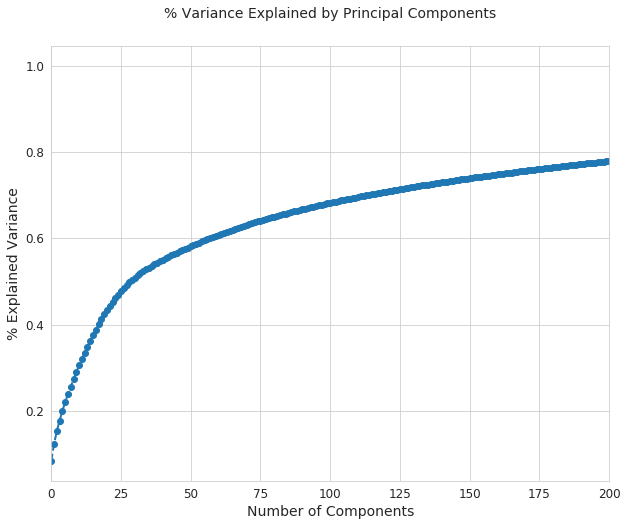

In [87]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [88]:
pca=PCA(n_components=250,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 250 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 250 components is: 0.8071790914161422


In [91]:
X_train=X_pca_21[:34793]
Y_train=fs.iloc[:34793]['Target'].values
X_test=X_pca_21[34793:]
Y_test=fs.iloc[34793:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [92]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,250).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9075963555887678
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26974  2717    29691
True         498  4604     5102
__all__    27472  7321    34793

Accuracy of the model for test data is: 0.9007817889169925
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6695   728     7423
True         135  1140     1275
__all__     6830  1868     8698



Logistic Regression
Accuracy of the model for training data is: 0.898973931537953
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26953  2738    29691
True         777  4325     5102
__all__    27730  7063    34793

Accuracy of the model for test data is: 0.8902046447459186
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6675   748     7423
True         207  1068     1275
__all__     6882  1816     8698



RandomForest Classifier
Accuracy of the model for training data is: 0.9183456442387836
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27088  2603    29691
True         238  4864     5102
__all__    27326  7467    34793

Accuracy of the model for test data is: 0.9049206714187169
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6738   685     7423
True         142  1133     1275
__all__     6880  1818     8698



Adaoost Classifier
Accuracy of the model for training data is: 0.8999511395970454
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27021  2670    29691
True         811  4291     5102
__all__    27832  6961    34793

Accuracy of the model for test data is: 0.8950333409979305
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6715   708     7423
True         205  1070     1275
__all__     6920  1778     8698



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9080562182048113
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27098  2593    29691
True         606  4496     5102
__all__    27704  7089    34793

Accuracy of the model for test data is: 0.9008967578753736
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6732   691     7423
True         171  1104     1275
__all__     6903  1795     8698



ExtraTree Classifier
Accuracy of the model for training data is: 0.9209898542810335
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27089  2602    29691
True         147  4955     5102
__all__    27236  7557    34793

Accuracy of the model for test data is: 0.9058404230857668
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6738   685     7423
True         134  1141     1275
__all__     6872  1826     8698



Bagging Classifier
Accuracy of the model for training data is: 0.9183456442387836
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27088  2603    29691
True         238  4864     5102
__all__    27326  7467    34793

Accuracy of the model for test data is: 0.9046907335019545
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6728   695     7423
True         134  1141     1275
__all__     6862  1836     8698



Neural Network-1
The accuracy of the model on training data is: 0.9140056908015867


Predicted  False  True  __all__
Actual                         
False      26848  2843    29691
True         149  4953     5102
__all__    26997  7796    34793

The accuracy of the model on test data is: 0.8938836514141182


Predicted  False  True  __all__
Actual                         
False       6600   823     7423
True         100  1175     1275
__all__     6700  1998     8698

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [93]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [94]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.907596,4604.0,26974.0,2717.0,498.0,0.091509,0.097609
LogisticRegression,0.898974,4325.0,26953.0,2738.0,777.0,0.092216,0.152293
RandomForestClassifier,0.918346,4864.0,27088.0,2603.0,238.0,0.087670,0.046648
AdaBoostClassifier,0.899951,4291.0,27021.0,2670.0,811.0,0.089926,0.158957
GradientBoostingClassifier,0.908056,4496.0,27098.0,2593.0,606.0,0.087333,0.118777
ExtraTreeClassifier,0.920990,4955.0,27089.0,2602.0,147.0,0.087636,0.028812
BaggingClassifier,0.918346,4864.0,27088.0,2603.0,238.0,0.087670,0.046648
Neural Network-1,0.914006,4953.0,26848.0,2843.0,149.0,0.095753,0.029204


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.900782,1140.0,6695.0,728.0,135.0,0.098074,0.105882,0.898022,0.685619
LogisticRegression,0.890205,1068.0,6675.0,748.0,207.0,0.100768,0.162353,0.868440,0.641248
RandomForestClassifier,0.904921,1133.0,6738.0,685.0,142.0,0.092281,0.111373,0.898173,0.692717
AdaBoostClassifier,0.895033,1070.0,6715.0,708.0,205.0,0.095379,0.160784,0.871918,0.652384
GradientBoostingClassifier,0.900897,1104.0,6732.0,691.0,171.0,0.093089,0.134118,0.886397,0.675394
ExtraTreeClassifier,0.905840,1141.0,6738.0,685.0,134.0,0.092281,0.105098,0.901311,0.697049
BaggingClassifier,0.904691,1141.0,6728.0,695.0,134.0,0.093628,0.105098,0.900637,0.694487
Neural Network-1,0.893884,1175.0,6600.0,823.0,100.0,0.110872,0.078431,0.905349,0.681661


In [95]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')